In [1]:
!pip install pyspark
!pip install python-dotenv

In [2]:
from pyspark.sql import SparkSession
from dotenv import load_dotenv
import os
from pyspark.sql.functions import explode, col, to_timestamp, substring
from pyspark.sql.types import StructType, StructField, StringType, LongType, BooleanType, ArrayType

In [3]:
from google.colab import userdata


storage_account_name = userdata.get("AZURE_ACCOUNT_NAME")
storage_account_key = userdata.get("AZURE_STORAGE_KEY")

storage_container_name = "kaggle-datasets"
parquet_blob_name = "github-dataset-full.parquet"

In [4]:
# Creating Spark session
spark = SparkSession.builder \
    .appName("Read Parquet from Azure Blob Storage") \
    .config(f"spark.hadoop.fs.azure.account.key.{storage_account_name}.blob.core.windows.net", storage_account_key) \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.3.2,com.microsoft.azure:azure-storage:8.6.6") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# Remove garbage error texts
spark.sparkContext.setLogLevel("ERROR")

 Analytics Steps

 1.Load Parquet Files

In [10]:
#Read the data from main file
users_df = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/clean_data/non_list_data"
)

In [11]:
#Read the data from main file
commits_df = spark.read.parquet(
    "wasbs://kaggle-datasets@matthewleffler1.blob.core.windows.net/clean_data/commit_list_data"
)

In [15]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, coalesce, lit

2.Aggregate Developer Activity per User

In [16]:
commit_counts = commits_df.groupBy("committer_id").agg(count("*").alias("commit_count"))

The above code groups all commits by user (committer_id) and counts how many commits each user made. The result is a table with each user's ID and their total number of commits.

In [18]:
users_with_commits = users_df.join(
    commit_counts,
    users_df.id == commit_counts.committer_id,
    how="left"
)

This left joins the users_df with commit_counts, matching id from users with committer_id from commits, and keeps all users even those with no commits.

In [20]:
users_with_commits = users_with_commits.withColumn(
    "commit_count",
    coalesce("commit_count", lit(0))
)

Some users did not have any commits, so NaN appears. We replace it with 0.

3. Compute Developer Activity Score

In [22]:
users_with_score = users_with_commits.withColumn(
    "activity_score",
    3 * col("commit_count") +
    2 * col("public_repos") +
    1 * col("followers") +
    0.5 * col("public_gists")
)

This creates a new column called activity_score by:

Giving more importance to commits (×3)

Adding weight to public repos (×2), followers (×1), and gists (×0.5)

It uses col("...") to reference columns in PySpark.

Fix: Normalize Company Names

In [83]:
from pyspark.sql.functions import lower, trim, regexp_replace

# Clean company names: lowercase, remove '@', strip spaces
users_normalized = users_with_score.withColumn(
    "company_cleaned",
    trim(lower(regexp_replace(col("company"), "@", "")))
).withColumn(
    "location",
    trim(lower(col("location")))
)

This will convert:

"@Microsoft " → "microsoft"

" Microsoft" → "microsoft"

"MICROSOFT" → "microsoft"

In [91]:
users_filtered = users_normalized.filter(
    col("company_cleaned").isNotNull() &
    (col("company_cleaned") != "") &
    (col("company_cleaned") != "none") &
    col("location").isNotNull() &
    (col("location") != "") &
    (col("location") != "none")
)

Filter the Null company values

5.Aggregate by Company

In [92]:
company_scores = users_filtered.groupBy("company_cleaned").sum("activity_score") \
    .withColumnRenamed("sum(activity_score)", "activity_score")


 This groups all users by company and sums their activity scores.

In [93]:
from pyspark.sql.window import Window
from pyspark.sql.functions import count, row_number

location_counts = users_filtered.groupBy("company_cleaned", "location").agg(count("*").alias("count"))

# Rank locations per company
windowSpec = Window.partitionBy("company_cleaned").orderBy(col("count").desc())

top_locations = location_counts.withColumn("rank", row_number().over(windowSpec)) \
    .filter(col("rank") == 1) \
    .drop("count", "rank")


This just renames the column to keep it clean.

In [94]:
top_20 = company_scores.orderBy(col("activity_score").desc()).limit(20)

In [95]:
top_20_with_location = top_20.join(top_locations, on="company_cleaned", how="left")

This sorts companies by total activity and takes the top 200.

In [97]:
top_20_with_location.orderBy(col("activity_score").desc()).show(truncate=False)

+--------------------------+--------------+-----------------+
|company_cleaned           |activity_score|location         |
+--------------------------+--------------+-----------------+
|microsoft                 |581376.5      |redmond, wa      |
|cocoapods                 |508770.0      |the astral cloud |
|google                    |435740.0      |mountain view, ca|
|freelance                 |200064.0      |ukraine          |
|ibm                       |182773.0      |austin, tx       |
|thoughtworks              |178229.0      |bangalore        |
|freelancer                |156139.0      |india            |
|facebook                  |154310.0      |menlo park, ca   |
|student                   |136326.0      |india            |
|tencent                   |135076.5      |shenzhen         |
|red hat                   |133002.5      |raleigh, nc      |
|alibaba                   |120691.0      |hangzhou         |
|carnegie mellon university|117617.5      |pittsburgh, pa   |
|baidu  

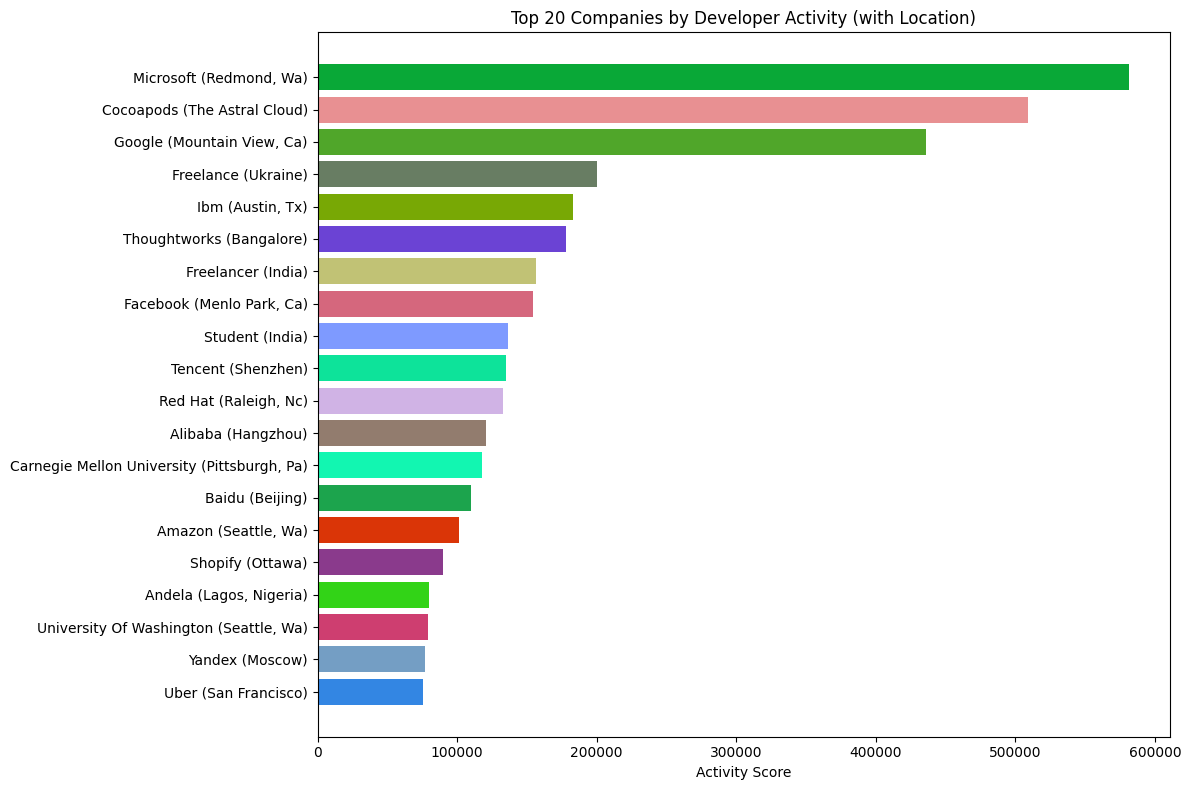

In [99]:
# Collect top 20 with location
top_20_pd = top_20_with_location.orderBy("activity_score", ascending=False).limit(20).toPandas()

import matplotlib.pyplot as plt
import numpy as np

# Add a label that combines company and location
top_20_pd["label"] = top_20_pd["company_cleaned"].str.title() + " (" + top_20_pd["location"].fillna("Unknown").str.title() + ")"

# Generate random colors
colors = np.random.rand(len(top_20_pd), 3)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(top_20_pd["label"], top_20_pd["activity_score"], color=colors)
plt.xlabel("Activity Score")
plt.title("Top 20 Companies by Developer Activity (with Location)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## SQL query for above steps
-- 1. Count commits per user

WITH commit_counts AS (

  SELECT

    committer_id,

    COUNT(*) AS commit_count

  FROM commits

  GROUP BY committer_id

),


-- 2. Join with users and compute activity score

users_enriched AS (

  SELECT

    LOWER(TRIM(REPLACE(u.company, '@', ''))) AS company_cleaned,

    LOWER(TRIM(u.location)) AS location,

    COALESCE(c.commit_count, 0) AS commit_count,
    
    u.public_repos,

    u.followers,

    u.public_gists,

    (

      3 * COALESCE(c.commit_count, 0) +

      2 * u.public_repos +

      1 * u.followers +

      0.5 * u.public_gists

    ) AS activity_score

  FROM users_with_score u

  LEFT JOIN commit_counts c ON u.id = c.committer_id

  WHERE u.company IS NOT NULL AND TRIM(LOWER(u.company)) NOT IN ('', 'none')

),


-- 3. Sum activity score per company

company_scores AS (

  SELECT

    company_cleaned,

    SUM(activity_score) AS total_activity_score

  FROM users_enriched

  GROUP BY company_cleaned

),

-- 4. Find most common location per company

location_mode AS (

  SELECT

    company_cleaned,

    location,

    ROW_NUMBER() OVER (PARTITION BY company_cleaned ORDER BY COUNT(*) DESC) AS
    row_num

  FROM users_enriched

  WHERE location IS NOT NULL AND location != ''

  GROUP BY company_cleaned, location

)

-- 5. Final output: top 20 companies with top location

SELECT

  cs.company_cleaned AS company,

  cs.total_activity_score,

  lm.location

FROM

  company_scores cs

LEFT JOIN

  location_mode lm

  ON cs.company_cleaned = lm.company_cleaned AND lm.row_num = 1

ORDER BY

  cs.total_activity_score DESC
  
LIMIT 20;


In [130]:
top_500 = company_scores.orderBy(col("activity_score").desc()).limit(500)

In [133]:
top_500_with_location = top_500.join(top_locations, on="company_cleaned", how="left")
print("Row count:", top_500_with_location.count())  # ← should print 500

Row count: 500


Download Top 500 companies data in a Excel file

In [134]:
# Install Excel writer
!pip install -q openpyxl

# Convert Spark DataFrame to Pandas
top_500_pd = top_500_with_location.toPandas()

# Save to Excel file
file_name = "top_500_companies_activities.xlsx"
top_500_pd.to_excel(file_name, index=False, engine="openpyxl")

# Download the file to your machine
from google.colab import files
files.download(file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>